In [1]:
import os
import pickle as pkl
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
BASE_PATH = "/home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit"

METHODS = {p: os.path.join(BASE_PATH, p) for p in os.listdir(BASE_PATH)}
# Shortcuts
BDT1 = "binary_digital_tracing_order_1"
BDT2 = "binary_digital_tracing_order_2"
UNMITIGATED = "no_intervention"
ORACLE = "oracle"
TRANSFORMER = lambda name: f"transformer{name}"

In [3]:
METHODS

{'binary_digital_tracing_order_1': '/home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/binary_digital_tracing_order_1',
 'binary_digital_tracing_order_2': '/home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/binary_digital_tracing_order_2',
 'no_intervention': '/home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/no_intervention',
 'oracle': '/home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/oracle',
 'transformerAVID-WAVE-652B': '/home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/transformerAVID-WAVE-652B',
 'transformerSCARLET-DAWN-653A': '/home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/transformerSCARLET-DAWN-653A'}

In [4]:
def load_tracker_data(method, condition=lambda people, days, init, uptake, seed: True): 
    pickles, paths = [], []
    sims = os.listdir(METHODS[method])
    for sim in sims: 
        sim_stats = sim.split("_")
        people = int(sim_stats[2].split("-")[-1])
        days = int(sim_stats[3].split("-")[-1])
        init = float(sim_stats[4].split("-")[-1])
        uptake = float(sim_stats[5].split("-")[-1])
        seed = int(sim_stats[6].split("-")[-1])
        if condition(people, days, init, uptake, seed): 
            sim_path = os.path.join(METHODS[method], sim)
            for artefact in os.listdir(sim_path): 
                if not artefact.startswith("tracker_data"):
                    continue
                artefact_path = os.path.join(sim_path, artefact)
                print(f"Loading artefact: {artefact_path}")
                with open(artefact_path, "rb") as f: 
                    pickles.append(pkl.load(f))
                paths.append(artefact_path)
    return pickles, paths

In [19]:
# # This is commented out to prevent accidental overwriting
stats = {}

In [20]:
exclude = {}
# include = {ORACLE}
include = METHODS

for method in include: 
    if method in exclude: 
        continue
    print(f"---------{method}----------")
    pickles, _ = load_tracker_data(method)
    stats[method] = defaultdict(list)
    for pickle in pickles: 
        stats[method]["cases"].append(pickle["cases_per_day"])
        stats[method]["infected"].append(sum(pickle["cases_per_day"]))
        stats[method]["effective_contacts"].append(pickle["effective_contacts_since_intervention"])
        stats[method]["expected_mobility"].append(pickle["expected_mobility"])
        stats[method]["rec_level"].append(pickle["humans_intervention_level"])
        stats[method]["outside_daily_contacts"].append(pickle["outside_daily_contacts"])
        stats[method]["outside_daily_contacts"].append(pickle["outside_daily_contacts"])
        stats[method]["outside_effective_contacts"].append(np.mean(pickle["outside_daily_contacts"][pickle["intervention_day"]:]))
    del pickles

---------binary_digital_tracing_order_1----------
Loading artefact: /home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/binary_digital_tracing_order_1/sim_v2_people-1000_days-30_init-0.01_uptake-0.8415_seed-5010_20200613-233515_972797/tracker_data_n_1000_seed_5010_20200613-235221_.pkl
Loading artefact: /home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/binary_digital_tracing_order_1/sim_v2_people-1000_days-30_init-0.01_uptake-0.8415_seed-5001_20200613-233452_315715/tracker_data_n_1000_seed_5001_20200613-235127_.pkl
Loading artefact: /home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/binary_digital_tracing_order_1/sim_v2_people-1000_days-30_init-0.01_uptake-0.8415_seed-5003_20200613-233451_744837/tracker_data_n_1000_seed_5003_20200613-234558_.pkl
Loading artefact: /home/nrahaman/python/simulator/work/fancyplots_bigomo_careful_biginit/binary_digital_tracing_order_1/sim_v2_people-1000_days-30_init-0.01_uptake-0.8415_seed-5004_2020

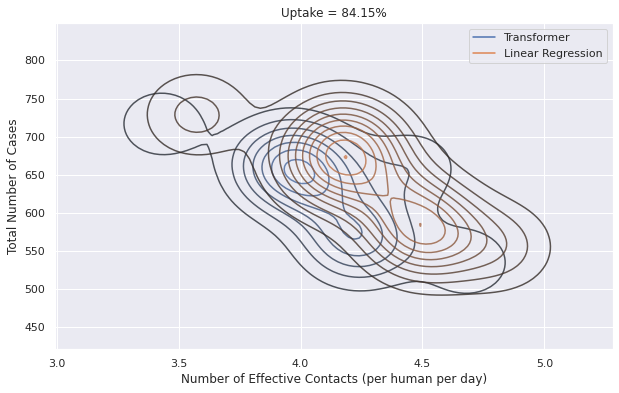

In [27]:
# ------------------------------CONTROL PANEL--------------------------------

labels = {
    UNMITIGATED: "Unmitigated",
    BDT1: "BDT1", 
    BDT2: "BDT2", 
    TRANSFORMER("AVID-WAVE-652B"): "Transformer", 
    TRANSFORMER("SCARLET-DAWN-653A"): "Linear Regression",
    ORACLE: "Oracle",
}

exclude = [UNMITIGATED]
include = [TRANSFORMER("AVID-WAVE-652B"), TRANSFORMER("SCARLET-DAWN-653A")]

plot_type = "kde"
kde_alpha = 0.8

x_key = "outside_effective_contacts"
y_key = "infected"
# ---------------------------------------------------------------------------

# ---------------------------------------------------------------------------
plt.figure(figsize=(10, 6))
ax = plt.gca()
for method, stat in stats.items(): 
    if method in exclude or method not in include: 
        continue
    if plot_type == "kde":
        sns.kdeplot(stat[x_key], stat[y_key], ax=ax, 
                    label=labels[method], shade=False, alpha=kde_alpha)
    elif plot_type == "scatter":
        plt.scatter(stat[x_key], stat[y_key], 
                label=labels[method])
plt.xlabel("Number of Effective Contacts (per human per day)")
plt.ylabel("Total Number of Cases")
plt.legend()
plt.title("Uptake = 84.15%")
plt.show()

In [22]:
pretty_x = x_key.replace("_", " ").title()
pretty_y = y_key.replace("_", " ").title()
for method in METHODS: 
    if method in exclude or method not in include:
        continue
    ratio = np.array(stats[method][y_key]) / np.array(stats[method][x_key])
    print(f"Method: {labels[method]} >> ")
    print(f"{pretty_y}/{pretty_x} (Mean)    : {ratio.mean():.4f}")
    print(f"{pretty_y}/{pretty_x} (Std)     : {ratio.std():.4f}")
    print(f"{pretty_y}/{pretty_x} (Median)  : {np.median(ratio):.4f}")
    

Method: BDT1 >> 
Infected/Outside Effective Contacts (Mean)    : 156.5481
Infected/Outside Effective Contacts (Std)     : 25.9473
Infected/Outside Effective Contacts (Median)  : 162.8571
Method: BDT2 >> 
Infected/Outside Effective Contacts (Mean)    : 158.0219
Infected/Outside Effective Contacts (Std)     : 25.7138
Infected/Outside Effective Contacts (Median)  : 155.7466
Method: Unmitigated >> 
Infected/Outside Effective Contacts (Mean)    : 418.2300
Infected/Outside Effective Contacts (Std)     : 46.9042
Infected/Outside Effective Contacts (Median)  : 405.6477
Method: Oracle >> 
Infected/Outside Effective Contacts (Mean)    : 117.5180
Infected/Outside Effective Contacts (Std)     : 17.6423
Infected/Outside Effective Contacts (Median)  : 110.6460
Method: Transformer >> 
Infected/Outside Effective Contacts (Mean)    : 154.2714
Infected/Outside Effective Contacts (Std)     : 24.4237
Infected/Outside Effective Contacts (Median)  : 157.5730
Method: Linear Regression >> 
Infected/Outside Ef